# Test Vaex

To open RADIS databases

In [40]:
!ls -hs CH4-06_HITEMP2020.h5

2.0G CH4-06_HITEMP2020.h5


In [4]:
import vaex
vaex.open("~/.radisdb/CH4-06_HITEMP2020.h5")

ERROR:MainThread:vaex:error opening 'CH4-06_HITEMP2020.h5'
ERROR:vaex:error opening 'CH4-06_HITEMP2020.h5'


OSError: Cannot open CH4-06_HITEMP2020.h5 nobody knows how to read it.

First surprise : .h5 file generated by Radis through Pandas with pytables cannot be opened by Vaex.
This is because [Pandas's to_hdf returns a row-based HDF5 format while Vaex's uses column based HDF5](https://vaex.readthedocs.io/en/meta-v2.6.1/faq.html#Why-can't-I-open-a-HDF5-file-that-was-exported-from-a-pandas-DataFrame-via-the-.to_hdf?). 

Let's regenerate a Vaex-friendly HDF5  :

In [5]:
from radis.io.hitemp import fetch_hitemp
df = fetch_hitemp("CH4", verbose=2)

Using existing database HITEMP-CH4


MemoryError: Unable to allocate 1.66 GiB for an array with shape (223162884,) and data type float64

So despite my 16 GB RAM, Pandas is not able to load my RADIS-generated HDF5 CH4 database.

Switching to a smaller N2O dataset : 

In [51]:
from radis.io.hitemp import fetch_hitemp
from time import time
t0 = time()
df = fetch_hitemp("N2O", verbose=2)
print(time()-t0)

Using existing database HITEMP-N2O
Returned existing database in 27.06
28.14509344100952


In [52]:
!ls -hs N2O-04_HITEMP2019.h5

266M N2O-04_HITEMP2019.h5


In [53]:
from time import time
t0 = time()
df = vaex.from_pandas(df)
print(time()-t0)

6.951995134353638


Now let's export it back to a column-based, VAEX friendly HDF5 : 

In [54]:
from time import time
t0 = time()
df.export("~/.radisdb/N2O-04_HITEMP2019.hdf5")
print(time()-t0)

12.48684811592102


Now let's re-open the HDF5 and start lazy-evaluating it : 


In [55]:
%timeit -n 3           df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")

15.3 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [56]:
df.column_names

['id',
 'iso',
 'wav',
 'int',
 'A',
 'airbrd',
 'selbrd',
 'El',
 'Tdpair',
 'Pshft',
 'globu',
 'globl',
 'locu',
 'locl',
 'ierr',
 'iref',
 'lmix',
 'gp',
 'gpp']

Trying some plots : 

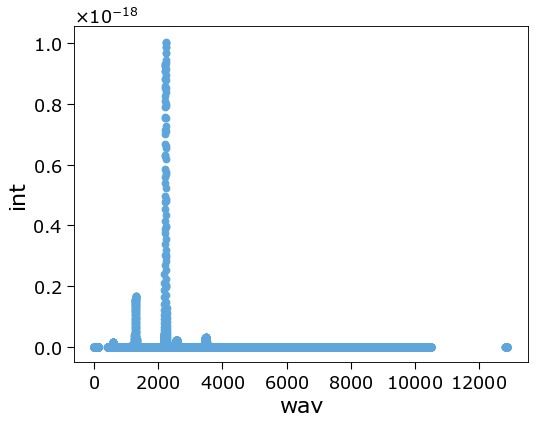

In [57]:
df.viz.scatter("wav", "int", length_check=False, length_limit=200000)
# This is just a wrapper to Matplotlib's Scatter : small data.

In [ ]:
t0 = time()
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
print(len(df), "lines")
df.viz.histogram(df.wav)
print(time()-t0)

0.3563868999481201


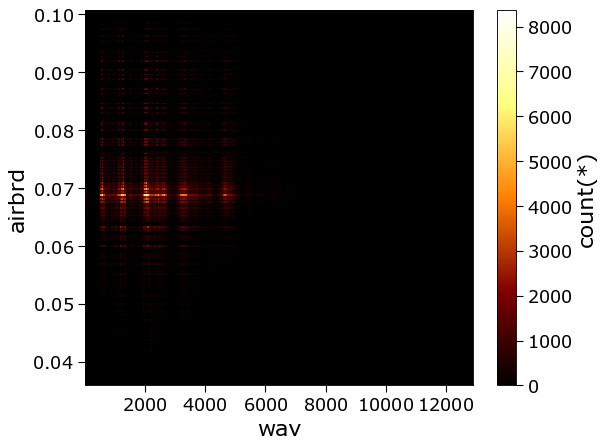

In [59]:
t0 = time()
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
df.viz.heatmap(df.wav, df.airbrd)
print(time()-t0)

## First optimization : use Vaex for all I/O operations, Pandas for the current calculations.

In [4]:
from time import time
import vaex

Exchange of data from Vaex to Pandas : 

In [5]:
t0 = time() 
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
df_pandas = df.to_pandas_df()
print(time()-t0)

7.833287477493286


In [2]:
t0 = time() 
import pandas as pd
df_pandas2 = pd.read_hdf("~/.radisdb/N2O-04_HITEMP2019.h5")
print(time()-t0)

28.142656087875366


First conclusion : 
> if is much faster to read a VAEX dataFrame and convert to Pandas that read the (compressed/indexable) Pandas dataFrame directly  (even with full RAM available !)

In [7]:
df_pandas

,id,iso,wav,int,A,airbrd,selbrd,El,Tdpair,Pshft,globu,globl,locu,locl,ierr,iref,lmix,gp,gpp
0,4,4,0.791154,1.022000e-28,1.245000e-09,0.0986,0.127,0.0000,0.75,0.0,0 0 0 0,0 0 0 0,,R 0e,636650,9 6 3 1 1 0,,27.0,9.0
1,4,1,0.838022,6.980000e-26,1.700000e-09,0.0986,0.127,0.0000,0.75,0.0,1 0 0 0 0,1 0 0 0 0,,R 0e,006650,0 0 3 1 1 0,,27.0,9.0
2,4,4,1.582305,8.172000e-28,1.201000e-08,0.0931,0.120,0.7912,0.75,0.0,0 0 0 0,0 0 0 0,,R 1e,636650,9 6 3 1 1 0,,45.0,27.0
3,4,4,1.583031,3.585000e-29,9.022000e-09,0.0931,0.120,585.0159,0.75,0.0,0 1 1 0,0 1 1 0,,R 1e,336650,9 6 3 1 1 0,,45.0,27.0
4,4,4,1.585880,3.598000e-29,9.071000e-09,0.0931,0.120,585.0173,0.75,0.0,0 1 1 0,0 1 1 0,,R 1f,336650,9 6 3 1 1 0,,45.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626420,4,1,12899.037134,3.294000e-27,1.319000e-05,0.0770,0.093,193.5455,0.67,0.0,3 0 0 0 6,1 0 0 0 0,,R 21e,333330,11 8 4 2 2 0,,405.0,387.0
3626421,4,1,12899.069827,3.695000e-27,1.310000e-05,0.0806,0.096,128.2008,0.68,0.0,3 0 0 0 6,1 0 0 0 0,,R 17e,333330,11 8 4 2 2 0,,333.0,315.0
3626422,4,1,12899.107692,3.424000e-27,1.318000e-05,0.0777,0.094,175.9535,0.67,0.0,3 0 0 0 6,1 0 0 0 0,,R 20e,333330,11 8 4 2 2 0,,387.0,369.0
3626423,4,1,12899.124064,3.628000e-27,1.313000e-05,0.0794,0.095,143.2811,0.68,0.0,3 0 0 0 6,1 0 0 0 0,,R 18e,333330,11 8 4 2 2 0,,351.0,333.0


In [8]:
df_pandas2

,id,iso,wav,int,A,airbrd,selbrd,El,Tdpair,Pshft,globu,globl,locu,locl,ierr,iref,lmix,gp,gpp
0,4,4,0.791154,1.022000e-28,1.245000e-09,0.0986,0.127,0.0000,0.75,0.0,0 0 0 0,0 0 0 0,,R 0e,636650,9 6 3 1 1 0,,27.0,9.0
1,4,1,0.838022,6.980000e-26,1.700000e-09,0.0986,0.127,0.0000,0.75,0.0,1 0 0 0 0,1 0 0 0 0,,R 0e,006650,0 0 3 1 1 0,,27.0,9.0
2,4,4,1.582305,8.172000e-28,1.201000e-08,0.0931,0.120,0.7912,0.75,0.0,0 0 0 0,0 0 0 0,,R 1e,636650,9 6 3 1 1 0,,45.0,27.0
3,4,4,1.583031,3.585000e-29,9.022000e-09,0.0931,0.120,585.0159,0.75,0.0,0 1 1 0,0 1 1 0,,R 1e,336650,9 6 3 1 1 0,,45.0,27.0
4,4,4,1.585880,3.598000e-29,9.071000e-09,0.0931,0.120,585.0173,0.75,0.0,0 1 1 0,0 1 1 0,,R 1f,336650,9 6 3 1 1 0,,45.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26420,4,1,12899.037134,3.294000e-27,1.319000e-05,0.0770,0.093,193.5455,0.67,0.0,3 0 0 0 6,1 0 0 0 0,,R 21e,333330,11 8 4 2 2 0,,405.0,387.0
26421,4,1,12899.069827,3.695000e-27,1.310000e-05,0.0806,0.096,128.2008,0.68,0.0,3 0 0 0 6,1 0 0 0 0,,R 17e,333330,11 8 4 2 2 0,,333.0,315.0
26422,4,1,12899.107692,3.424000e-27,1.318000e-05,0.0777,0.094,175.9535,0.67,0.0,3 0 0 0 6,1 0 0 0 0,,R 20e,333330,11 8 4 2 2 0,,387.0,369.0
26423,4,1,12899.124064,3.628000e-27,1.313000e-05,0.0794,0.095,143.2811,0.68,0.0,3 0 0 0 6,1 0 0 0 0,,R 18e,333330,11 8 4 2 2 0,,351.0,333.0


### Further optimisation : 

What if we only load the relevant columns to the Pandas DataFrame that will then be used for the calculations ? Let's try; from HDF5; or through VaeX. Because VAex's HDF5 is column based it will probably be very easy. I expect that loading only some columns from Pandas's HDF5 may not yield significant performance. 

In [9]:
df_pandas.columns

Index(['id', 'iso', 'wav', 'int', 'A', 'airbrd', 'selbrd', 'El', 'Tdpair',
       'Pshft', 'globu', 'globl', 'locu', 'locl', 'ierr', 'iref', 'lmix', 'gp',
       'gpp'],
      dtype='object')

Out of these we'll select the one relevant for the computation of the populations in a spectrum, i.e.; "iso", "wav", "int", "El"  for the moment. 

In [10]:
t0 = time() 
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
df_pandas = df.to_pandas_df(column_names=["iso", "wav", "int", "El"])
print(time()-t0)

0.1795198917388916


Wow. That's much faster already !! 

In [11]:
t0 = time() 
import pandas as pd
df_pandas2 = pd.read_hdf("~/.radisdb/N2O-04_HITEMP2019.h5", columns=["iso", "wav", "int", "El"])
print(time()-t0)

22.85481858253479


In comparison, loading 4 out of 19 columns is about 70% as slow with Pandas. 

### Index per row

To be fair, let's do the reverse : let's load only specific isotopes; which are indexed by rows in Pandas's HDF5 ! 

In [14]:
t0 = time() 
import pandas as pd
df_pandas2 = pd.read_hdf("~/.radisdb/N2O-04_HITEMP2019.h5", where="iso==1")
print(time()-t0)

30.680099725723267


In [16]:
set(df_pandas2.iso)

{1}

So I did work; but I'm quite disapointed here; I expected some improvement in performances ! 
That's what's used in [RADIS 0.9.29](https://github.com/radis/radis/blob/develop/radis/io/hdf5.py#L87), though. 

Let's try with Vaex : 

In [23]:
t0 = time()
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
df.select(df.iso == 1)
df_pandas = df.to_pandas_df(selection=True)
print(time()-t0)

7.043155670166016


In [24]:
set(df_pandas.iso)

{1}

So it worked here ; and the selection itself was extremelly fast in Vaex. 

Maybe a sorted range may be more advantageous for Pandas's HDF5 ? Let's load only the 2000 - 5000 cm-1 range : 

In [25]:
t0 = time() 
import pandas as pd
df_pandas2 = pd.read_hdf("~/.radisdb/N2O-04_HITEMP2019.h5", where="wav > 2000 and wav < 5000")
print(time()-t0)

19.66069459915161


In [26]:
df_pandas2.wav.min(), df_pandas2.wav.max()

(2000.000599, 4999.99425)

In [27]:
t0 = time()
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
df.select(df.wav > 2000 and df.wav < 5000)
df_pandas = df.to_pandas_df(selection=True)
print(time()-t0)

6.15947961807251


In [28]:
df_pandas2.wav.min(), df_pandas2.wav.max()

(2000.000599, 4999.99425)

Well; still the upper hand for VaeX.

We know what this means : if we combine everything, for a practical example of single-isotope ; 2000 - 5000 cm-1; computing the populations : 


Pure Pandas : 

In [29]:
t0 = time() 
import pandas as pd
df_pandas2 = pd.read_hdf("~/.radisdb/N2O-04_HITEMP2019.h5", where="wav > 2000 and wav < 5000 and iso == 1", columns=["iso", "wav", "int", "El"])
print(time()-t0)

20.243298768997192


Vaex :

In [31]:
t0 = time()
df = vaex.open("~/.radisdb/N2O-04_HITEMP2019.hdf5")
df.select(df.wav > 2000 and df.wav < 5000 and df.iso == 1)
df_pandas = df.to_pandas_df(selection=True, column_names=["iso", "wav", "int", "El"])
print(time()-t0)

0.8617293834686279


So 23x faster, on a reasonably small dataset (remember than CH4 above didn't even manage to load on my machine -_- )  !

## Things to explore

Binby concept ? https://vaex.readthedocs.io/en/docs/tutorial.html#Statistics-on-N-d-grids


Build N-dimensional grid   https://vaex.readthedocs.io/en/docs/tutorial_jupyter.html

End goal for Lineshape project : how to build the Lineshape Grid the most efficiently ? This could be evaluated by looking at the HDF5 in a similar way.